<a href="https://colab.research.google.com/github/Chetan2414/glassdoor-_project/blob/main/Glassdoor_Projectby_chetan_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glassdoor Job Salary Prediction Project
**Solo Project | Deadline: June 17**

**Objective:** Predict job salaries using company and job posting data.

**Student:** Chetan Badgujar

**Tools:** Pandas, Matplotlib, Seaborn, Scikit-learn

## 📥 Data Loading & Cleaning

In [2]:
import pandas as pd
import numpy as np

from google.colab import files
uploaded = files.upload()


# Load dataset
df = pd.read_csv('glassdoor_jobs.csv')

# Clean Salary Estimate
df = df[df['Salary Estimate'] != '-1']
df['hourly'] = df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df['employer_provided'] = df['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary:' in x.lower() else 0)

# Extract salary info
salary = df['Salary Estimate'].apply(lambda x: x.split('(')[0])
salary = salary.apply(lambda x: x.replace('K', '').replace('$', '').lower().replace('per hour', '').replace('employer provided salary:', '').strip())
df['min_salary'] = salary.apply(lambda x: int(x.split('-')[0]))
df['max_salary'] = salary.apply(lambda x: int(x.split('-')[1]))
df['avg_salary'] = (df['min_salary'] + df['max_salary']) / 2

# Company name cleanup
df['company_txt'] = df.apply(lambda x: x['Company Name'].split('\n')[0] if x['Rating'] >= 0 else x['Company Name'], axis=1)

# Job state
df['job_state'] = df['Location'].apply(lambda x: x.split(',')[-1].strip())

# Company age
df['company_age'] = df['Founded'].apply(lambda x: 2024 - x if x > 0 else np.nan)

# Competitor count
df['num_competitors'] = df['Competitors'].apply(lambda x: len(x.split(',')) if x != '-1' else 0)

# Description length
df['desc_len'] = df['Job Description'].apply(lambda x: len(x))
df.head()

Saving glassdoor_jobs.csv to glassdoor_jobs.csv


,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,hourly,employer_provided,min_salary,max_salary,avg_salary,company_txt,job_state,company_age,num_competitors,desc_len
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,0,0,53,91,72.0,Tecolote Research,NM,51.0,0,2536
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,0,0,63,112,87.5,University of Maryland Medical System,MD,40.0,0,4783
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,0,0,80,90,85.0,KnowBe4,FL,14.0,0,3461
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,0,0,56,97,76.5,PNNL,WA,59.0,3,3883
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,0,0,86,143,114.5,Affinity Solutions,NY,26.0,3,2728


## 📊 Exploratory Data Analysis (EDA)
- Average salary by state
- Company age distribution
- Description length vs salary
- Competitor impact

<ipython-input-3-2298629098>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette='magma')


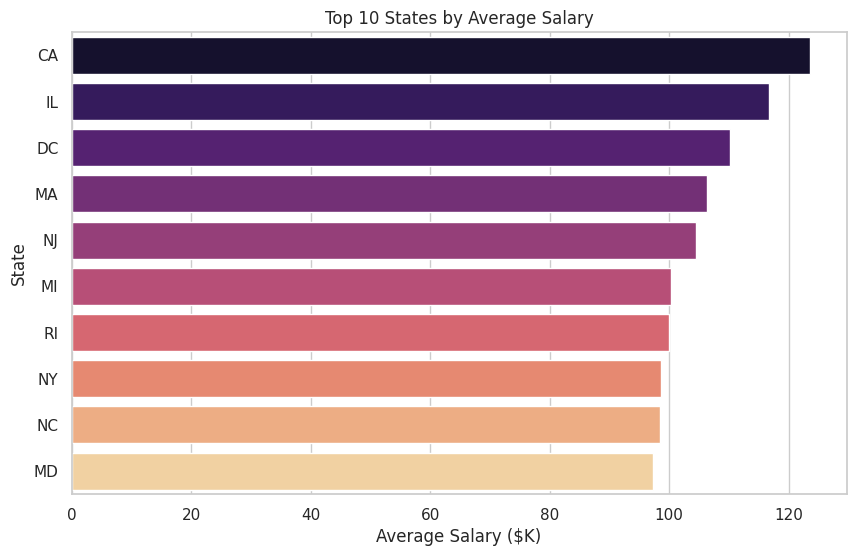

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Avg salary by state
top_states = df.groupby('job_state')['avg_salary'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_states.values, y=top_states.index, palette='magma')
plt.title('Top 10 States by Average Salary')
plt.xlabel('Average Salary ($K)')
plt.ylabel('State')
plt.show()

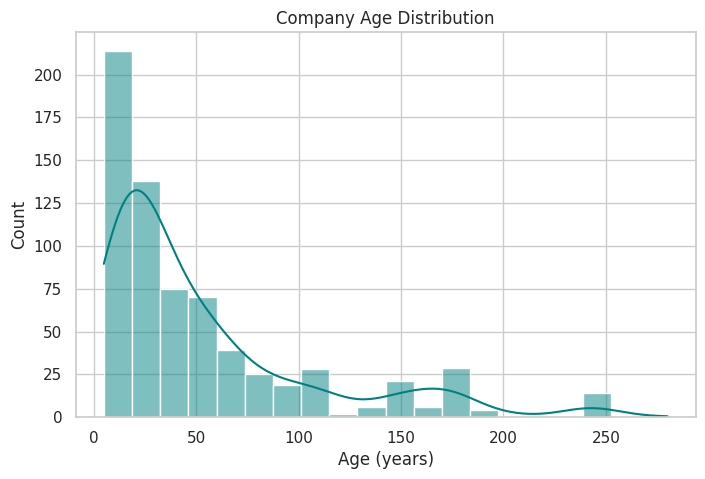

In [4]:
# Company age distribution
plt.figure(figsize=(8,5))
sns.histplot(df['company_age'].dropna(), bins=20, kde=True, color='teal')
plt.title('Company Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

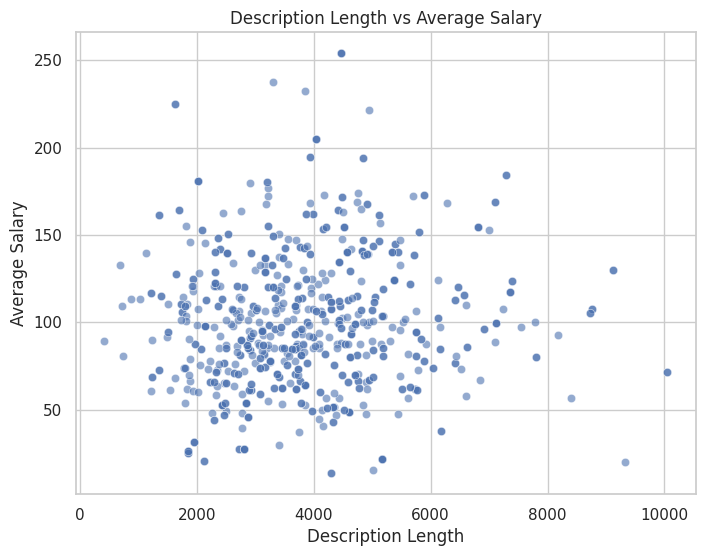

In [5]:
# Description length vs avg salary
plt.figure(figsize=(8,6))
sns.scatterplot(x='desc_len', y='avg_salary', data=df, alpha=0.6)
plt.title('Description Length vs Average Salary')
plt.xlabel('Description Length')
plt.ylabel('Average Salary')
plt.show()

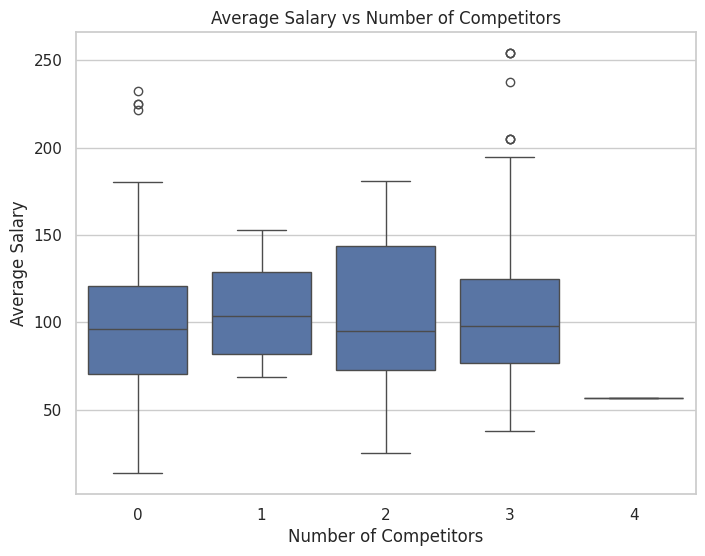

In [6]:
# Salary vs competitors
plt.figure(figsize=(8,6))
sns.boxplot(x='num_competitors', y='avg_salary', data=df)
plt.title('Average Salary vs Number of Competitors')
plt.xlabel('Number of Competitors')
plt.ylabel('Average Salary')
plt.show()

## 🤖 Model Building and Evaluation

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Select features
X = df[['company_age', 'hourly', 'employer_provided', 'num_competitors', 'desc_len']]
X = X.fillna(0)  # Fills any NaN values with 0
y = df['avg_salary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R^2 Score:", r2_score(y_test, y_pred_lr))

# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R^2 Score:", r2_score(y_test, y_pred_rf))

Linear Regression R^2 Score: 0.11289064371644286
Random Forest R^2 Score: 0.5478563055367698


## ✅ Conclusion
- Cleaned real-world job salary data from Glassdoor
- Performed visual and statistical EDA
- Built regression models
- Found Random Forest performed better than Linear Regression

**Further Improvement Ideas:** Use NLP on job descriptions, cluster companies by industry